In [392]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
%matplotlib inline

In [2]:
# Устанавливаем доступ к папке с файлами ДР
from google.colab import drive
 
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [3]:
# Загружаем csv файлы с гугл диска
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [4]:
# Создаем словарь для совместной обработки всех 6и НД
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

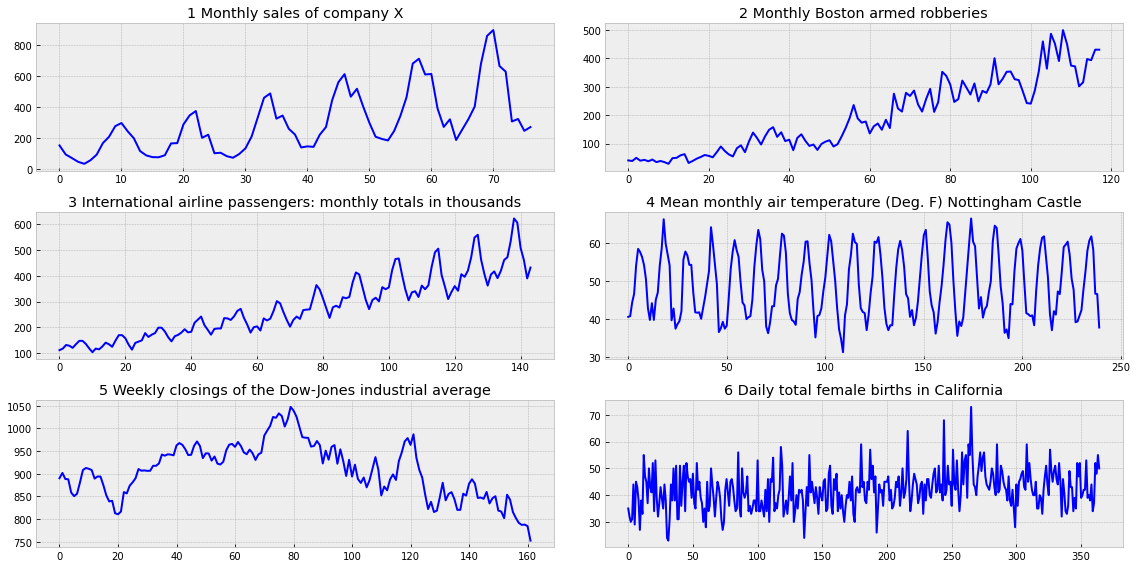

In [5]:
%matplotlib inline
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(str(i+1)+' '+key)
    plt.tight_layout()

In [6]:
# Функция тест Дики-Фуллера 
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return  dfoutput



In [7]:
# тест всех рядов и вывод результата
def test_series(_dict):
  for i, key in enumerate(_dict.keys()):
    df_series = pd.Series(_dict[key])
    if test_stationarity(df_series)['p-value'] < 0.05: stationary = True
    else: stationary = False    
    print(i+1, ' ', key, stationary)
    print(test_stationarity(df_series))
    print('_________________________')

In [8]:
# запускаем тест на всех рядах
test_series(all_series)

Results of Dickey-Fuller Test:
1   Monthly sales of company X False
Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64
_________________________
Results of Dickey-Fuller Test:
2   Monthly Boston armed robberies False
Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
_________________________
Results of Dickey-Fuller Test:
3   International airline passengers: monthly totals in thousands False
Results of Dickey-Fuller Test:
T

In [9]:
# Возьмем ряды 3(не стационарный) и 4(стационарный)  для исследования
airlines_passengers


,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [10]:
mean_monthly_temp

,Month,Deg
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1
...,...,...
235,1939-08,61.8
236,1939-09,58.2
237,1939-10,46.7
238,1939-11,46.6


# 1/ Модель скользящего среднего
*Курсив*

In [36]:
# Функция принимает датасет, разбивает на трейн и тест, строит предсказания на онсове модели скольз среднего, отрисовывает данные модели и тест и считает ошибку RMSE
def predict_ma(series):
  # разделяем на трейн и тест
    n_string = int(round(len(series)*0.5))
    train = series[:n_string]
    test = series[n_string:]
    n_pred = len(test)
    new_series = train.copy()
    _value = []
    for _ in range(n_pred):
        N = 7
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
        _value.append(new_series[-N:].mean()) 
    pred = pd.Series(_value, index = test.index )
    with plt.style.context('bmh'):
      plt.figure(figsize=(14, 4))
      plt.plot(test, color='blue',label='Test')
      plt.plot(pred, color='red', linewidth='4', label='Predict')
      plt.title('Moving Average model, rmse = '+str(round(mean_squared_error(test, pred, squared=False),2)))
      plt.legend()    



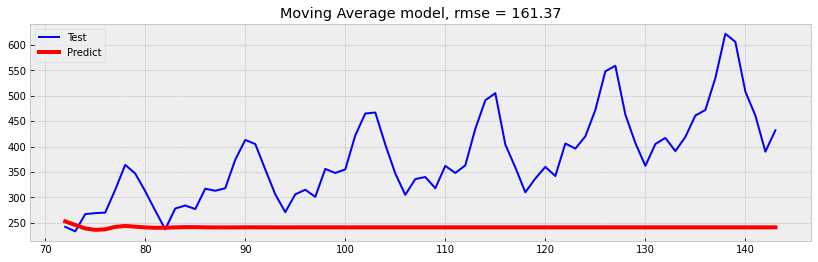

In [37]:
# для нестац ряда
predict_ma(airlines_passengers.Count)

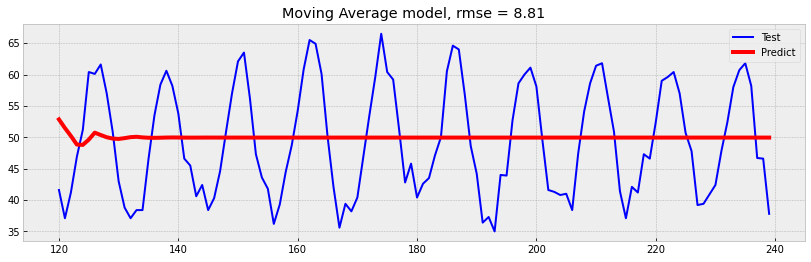

In [38]:
# для стац ряда
predict_ma(mean_monthly_temp.Deg)

Вывод: Как и предполагалось модель скользящего среднего непригодня для предсказания стац и нестац ряда, так как имеет свойство затухать

 # 2/ Модель взвешенного скользящего среднего




In [207]:
# Функция принимает датасет, разбивает на трейн и тест, строит предсказания на онсове модели скольз среднего, отрисовывает данные модели и тест и считает ошибку RMSE
def predict_wma(series):
  # разделяем на трейн и тест
    n_string = int(round(len(series)*0.5))
    train = series[:n_string]
    test = series[n_string:]
    n_pred = len(test)
    new_series = train.copy()
    _value = []
    weights = np.array([1,1,2,3,5,8,13])
    for _ in range(n_pred):
        N = len(weights)
        new_pred = sum(np.array(new_series[-N:])* weights)/sum(weights)
        new_series = new_series.append(pd.Series([new_pred]), ignore_index=True)
        _value.append(new_pred) 
    pred = pd.Series(_value, index = test.index )

    with plt.style.context('bmh'):
      plt.figure(figsize=(14, 4))
      plt.plot(test, color='blue',label='Test')
      plt.plot(pred, color='red', linewidth='4', label='Predict')
      plt.title('Weight Moving Average model, rmse = '+str(round(mean_squared_error(test, pred, squared=False),2)))
      plt.legend()  


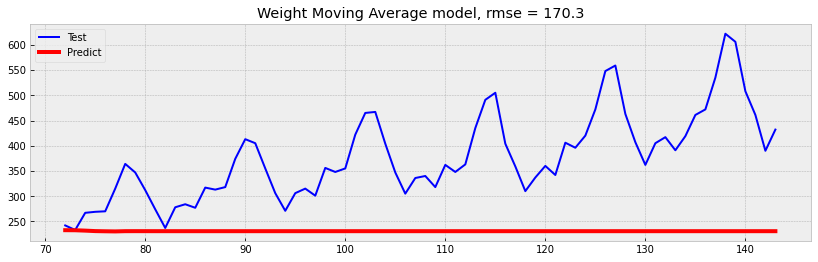

In [355]:
predict_wma(airlines_passengers.Count)

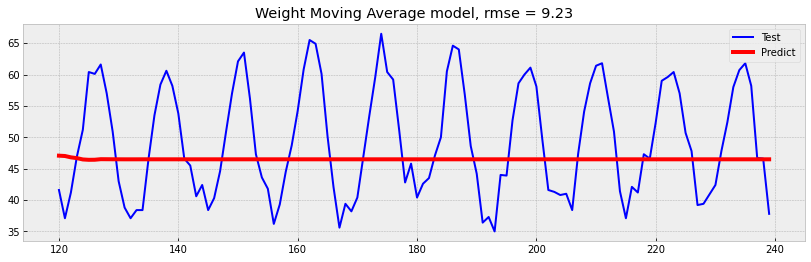

In [209]:
predict_wma(mean_monthly_temp.Deg)

Вывод: Модель всзевенного скользящего среднего показала еще худшие результаты. И это логично, т.к. "забывание" происходит быстрее за счет уменьшения весов к более старым данным ряда

 # 3/ Модель эскпоненциального сглаживания

In [225]:
def predict_ema(series):
 # разделяем на трейн и тест
  n_string = int(round(len(series)*0.5))
  train = series[:n_string]
  test = series[n_string:]
  result = [series[0]]
  alpha = 0.8
  for n in range(1, len(train)):
    result.append(alpha * series[n] + (1 - alpha) * result[n-1])
  predictions = [alpha * train[len(train) - 1] + (1 - alpha) * result[-1]]  
  for _ in range(len(test)-1):
    res = alpha * predictions[-1] + (1 - alpha) * result[-1]
    result.append(res)
    predictions.append(res)
  ser_res =  pd.Series(predictions, index = test.index )
  with plt.style.context('bmh'):
      plt.figure(figsize=(14, 4))
      plt.plot(test, color='blue',label='Test')
      plt.plot(ser_res, color='red', linewidth='4', label='Predict')
      plt.title('Exp Average model, rmse = '+str(round(mean_squared_error(test, ser_res, squared=False),2)))
      plt.legend()   


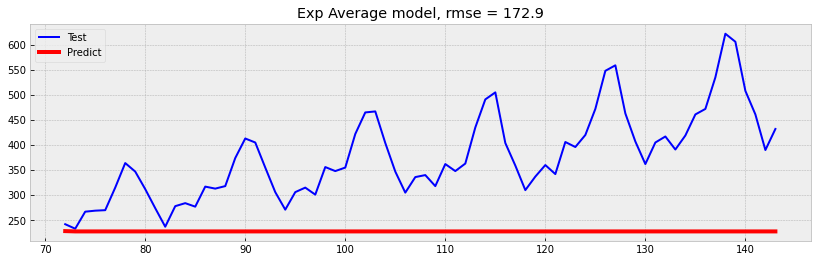

In [226]:
predict_ema(airlines_passengers.Count)

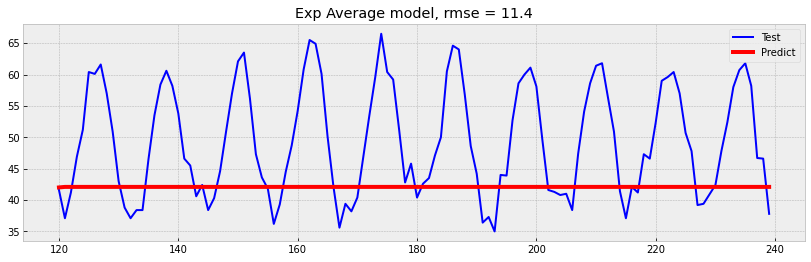

In [227]:
predict_ema(mean_monthly_temp.Deg)

Вывод: Модель экспоненциального  среднего тоже не годится.


```



# 4/ Модель двойного эскпоненциального сглаживания

In [318]:
def predict_dema(series, alpha, beta):
 # разделяем на трейн и тест
  n_string = int(round(len(series)*0.5))
  train = series[:n_string]
  test = series[n_string:]
  result = [series[0]]

  level, trend = series[0], series[1] - series[0]

  for n in range(1, len(train)):
    value = series[n]
    last_level, level = level, alpha*value + (1-alpha)*(level+trend)
    trend = beta*(level-last_level) + (1-beta)*trend
    result.append(level+trend)
  preds = []

  for n in range(len(test)):
    value = result[-1]
    last_level, level = level, alpha*value + (1-alpha)*(level+trend)
    trend = beta*(level-last_level) + (1-beta)*trend
    result.append(level+trend)
    preds.append(level+trend)
  ser_res =  pd.Series(preds, index = test.index )
  return ser_res, test
   


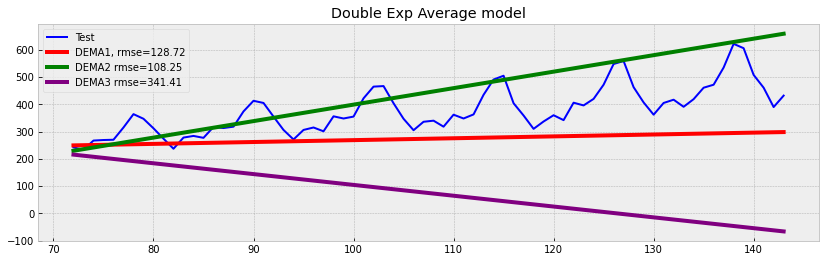

In [357]:

with plt.style.context('bmh'):
  plt.figure(figsize=(14, 4))
  plt.plot(test, color='blue',label='Test')
  ser_res1, test = predict_dema(airlines_passengers.Count,0.2,0.2)
  ser_res2, test = predict_dema(airlines_passengers.Count,0.8,0.8)
  ser_res3, test = predict_dema(airlines_passengers.Count,0.8,0.2)
  plt.plot(ser_res1, color='red', linewidth='4', label='DEMA1, rmse='+str(round(mean_squared_error(test, ser_res1, squared=False),2)))
  plt.plot(ser_res2, color='green', linewidth='4', label='DEMA2 rmse='+str(round(mean_squared_error(test, ser_res2, squared=False),2)))
  plt.plot(ser_res3, color='purple', linewidth='4', label='DEMA3 rmse='+str(round(mean_squared_error(test, ser_res3, squared=False),2)))
  plt.title('Double Exp Average model')
  plt.legend() 

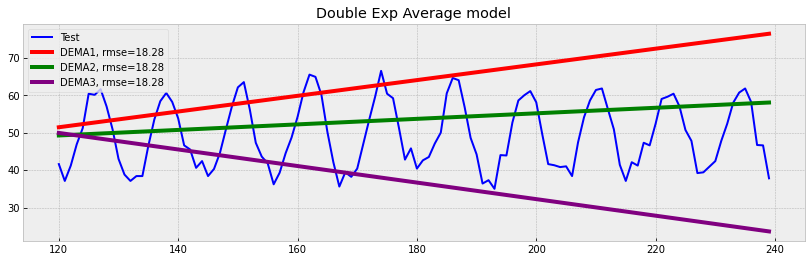

In [351]:

with plt.style.context('bmh'):
  plt.figure(figsize=(14, 4))
  plt.plot(test, color='blue',label='Test')
  ser_res1, test = predict_dema(mean_monthly_temp.Deg,0.2,0.2)
  ser_res2, test = predict_dema(mean_monthly_temp.Deg,0.1,0.1)
  ser_res3, test = predict_dema(mean_monthly_temp.Deg,0.3,0.2)
  plt.plot(ser_res1, color='red', linewidth='4', label='DEMA1, rmse='+str(round(mean_squared_error(test, ser_res1, squared=False),2)))
  plt.plot(ser_res2, color='green', linewidth='4', label='DEMA2, rmse='+str(round(mean_squared_error(test, ser_res1, squared=False),2)))
  plt.plot(ser_res3, color='purple', linewidth='4', label='DEMA3, rmse='+str(round(mean_squared_error(test, ser_res1, squared=False),2)))
  plt.title('Double Exp Average model')
  plt.legend() 

Вывод: Модель двойного экспоненциального  сглаживания начинает учитывать тренд и для рядов с трендом рез. улучшается

# 5/ Хольт-Винтерс

In [289]:
# определение тренда
def initial_trend(series, season_len):
  sum = 0.0
  for i in range(season_len):
    sum += float(series[i+season_len] - series[i]) 
  return sum / season_len

In [288]:
# определение сезонности
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [361]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [371]:
# предсказание на основе  параметров для серии
def pressision_series (alpha, betta, gamma, series):
  n_string = int(round(len(series)*0.5))
  train = series[:n_string]
  test = series[n_string:]
  pred = triple_exponential_smoothing(train, 12,alpha, betta, gamma,len(test))
  pres_ser = pd.Series(pred[n_string:], index = test.index)
  return pres_ser, train, test

In [385]:
alpha = 0.1
betta = 0.1
gamma = 0.2
series = airlines_passengers.Count
pres_ser, train, test = pressision_series(alpha, betta, gamma, series)

In [386]:
# отобрадение test b предсказаний, определение ошибки
def _plot(test,pres_ser):
  with plt.style.context('bmh'):
   plt.figure(figsize=(14, 6))
   plt.plot(test, color='blue',label='Test')
   plt.plot(pres_ser, color='red', linewidth='4', label='TEMA, rmse = '+str(round(mean_squared_error(test, pres_ser, squared=False),2)))
   plt.legend()

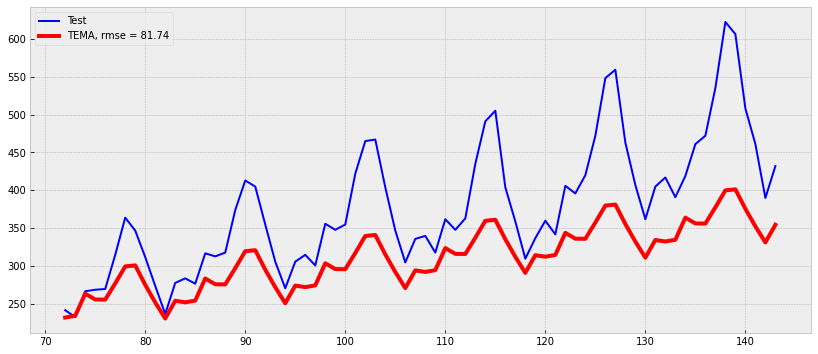

In [387]:
_plot(test,pres_ser)

In [389]:
# функция опреденения ошибки
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [390]:
#минимизация ошибки поббор параментров
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

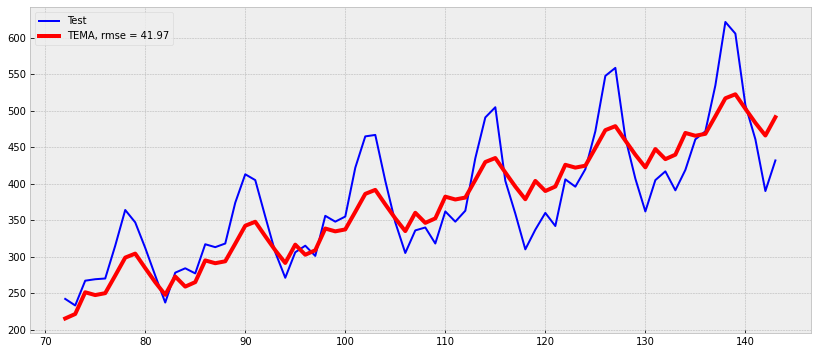

In [391]:
alpha, betta, gamma = opt.x
series = airlines_passengers.Count
pres_ser, train, test = pressision_series(alpha, betta, gamma, series)
_plot(test,pres_ser)

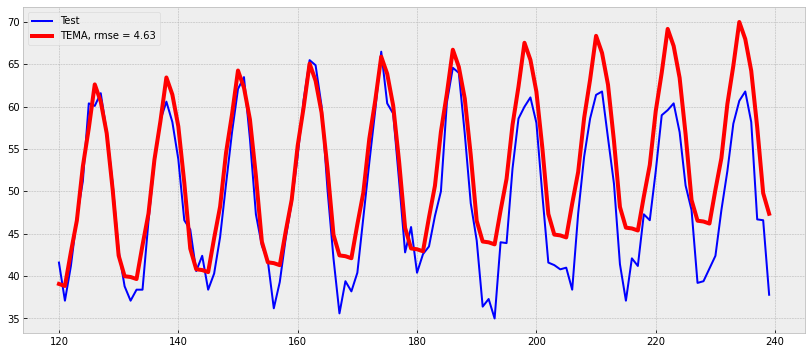

In [397]:
alpha = 0.1
betta = 0.1
gamma = 0.2
series = mean_monthly_temp.Deg
pres_ser, train, test = pressision_series(alpha, betta, gamma, series)
_plot(test,pres_ser)

In [398]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

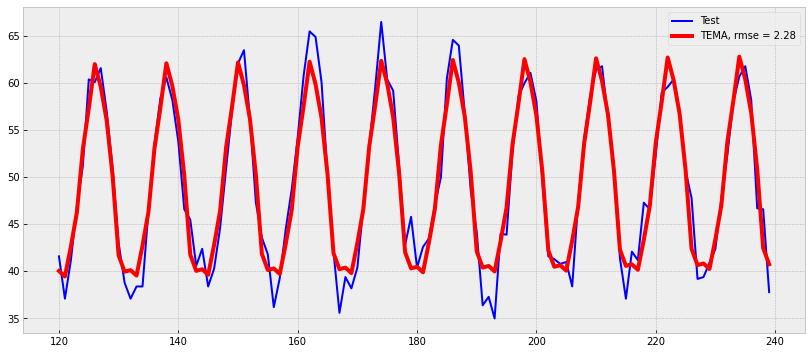

In [399]:
alpha, betta, gamma = opt.x
pres_ser, train, test = pressision_series(alpha, betta, gamma, series)
_plot(test,pres_ser)